In [2]:
from random import gauss as gs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from statsmodels.formula.api import ols
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import plotly.graph_objects as go

# Definitions 

In [3]:
def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    """
    Plot plotly time series of the original (og_ts) and predicted (pred_ts) time series values to check how our model performs.
    model_name: name of the model used for predictions
    og_ts_opacity: opacity of the original time series
    pred_ts_opacity: opacity of the predicted time series
    """
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed test set vs predicted energy MWH values using {}'.format(model_name),
                  xaxis_rangeslider_visible = True)
    fig.show()

In [4]:
def plot_timeseries(ts, title = 'og', opacity = 1):
    """
    Plot plotly time series of any given timeseries ts
    """
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = ts.index, y = ts.values, name = "observed",
                         line_color = 'lightslategrey', opacity = opacity))

    fig.update_layout(title_text = title,
                  xaxis_rangeslider_visible = True)
    fig.show()

In [5]:
#Loading the previously saved hourly energy for SDGE and SDGE hourly merged with weather data
sdge = pd.read_csv('SDGE_W.csv')

In [6]:
sdge = sdge.drop('Unnamed: 0', axis=1)
sdge.set_index("Date", inplace =True)

In [7]:
sdge.head()

SDGE  year  month  day  hour  weekday  season  \
Date                                                                        
2019-01-01 00:00:00  2372.497411  2019      1    1     0  Tuesday  winter   
2019-01-01 01:00:00  2698.751137  2019      1    1     1  Tuesday  winter   
2019-01-01 02:00:00  2777.672120  2019      1    1     2  Tuesday  winter   
2019-01-01 03:00:00  2799.193829  2019      1    1     3  Tuesday  winter   
2019-01-01 04:00:00  2761.883322  2019      1    1     4  Tuesday  winter   

                     holiday  HourlyDryBulbTemperature  \
Date                                                     
2019-01-01 00:00:00        1                      49.0   
2019-01-01 01:00:00        0                      47.0   
2019-01-01 02:00:00        0                      47.0   
2019-01-01 03:00:00        0                      47.0   
2019-01-01 04:00:00        0                      46.5   

                     HourlyRelativeHumidity  HourlyWindSpeed  
Date                                                          
2019-01-01 00:00:00                    71.0              0.0  
2019-01-01 01:00:00                    77.0              5.0  
2019-01-01 02:00:00                    63.0              6.0  
2019-01-01 03:00:00                    52.0              6.0  
2019-01-01 04:00:00                    51.5              5.5

# EDA
### Hourly
Hourly consumption is at it's highest during the night and this data is from covid times, to make sure any modeling can be used for future, we'd need to collect more historical data, previous to 2019. A lot of energy consumption is because of working hours and covid had resulted in a lot of shit downs which could've influenced the county economic life. 

Text(0.5, 1.0, 'Hourly Energy consumption in MWH averaged over 4 years (2019-22)')

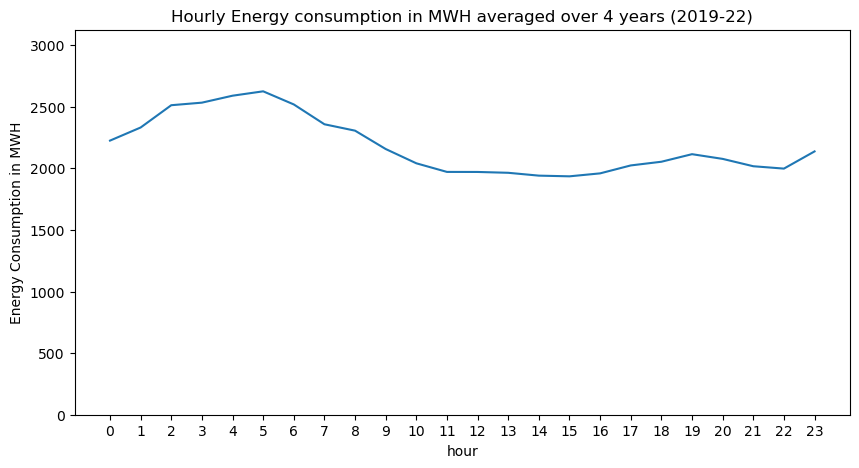

In [8]:
#Plotting average hourly load profile observed over the entire period 
sdge.groupby('hour')['SDGE'].mean().plot(figsize = (10,5))
plt.ylabel('Energy Consumption in MWH')
plt.ylim([0, max(sdge.groupby('hour')['SDGE'].mean()) + 500])
plt.xticks(sdge['hour'].unique())
plt.title('Hourly Energy consumption in MWH averaged over 4 years (2019-22)')

#### Monthly
The monthly consumption of energy as seen below peaks during summer time, sandiego is in the west cost and relatively has hotter summers than their winters are cold. Late summer and early autumn are typically the hottest times of the year. 

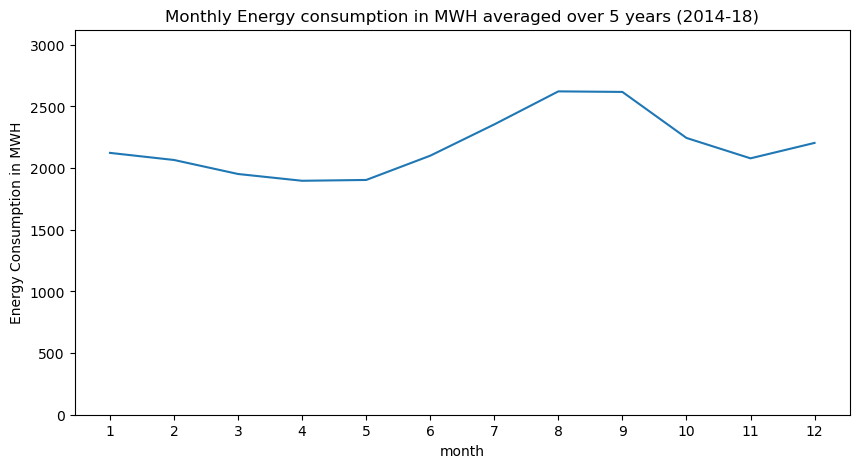

In [16]:
##Plotting average monthly load profile
sdge.groupby('month')['SDGE'].mean().plot(figsize = (10,5))
plt.ylabel('Energy Consumption in MWH')
plt.ylim([0, max(sdge.groupby('month')['SDGE'].mean()) + 500])
plt.xticks(sdge['month'].unique())
plt.title('Monthly Energy consumption in MWH averaged over 5 years (2014-18)')

#### Weekdays
We can see similar to our previous hourly data, consumtion is at it's peak during the night monday to friday and consumption is lower during weekends on sundat and saturday

In [18]:
#Using pivot table to create a dataframe having index as hours and columns as weekdays and each cell will contain the average consumption
w_hr = sdge.pivot_table(values='SDGE', index='hour', columns = 'weekday', aggfunc = 'mean')

Text(0.5, 1.0, 'Average energy consumption in MWH for each hour of each weekday averaged over 5 years')

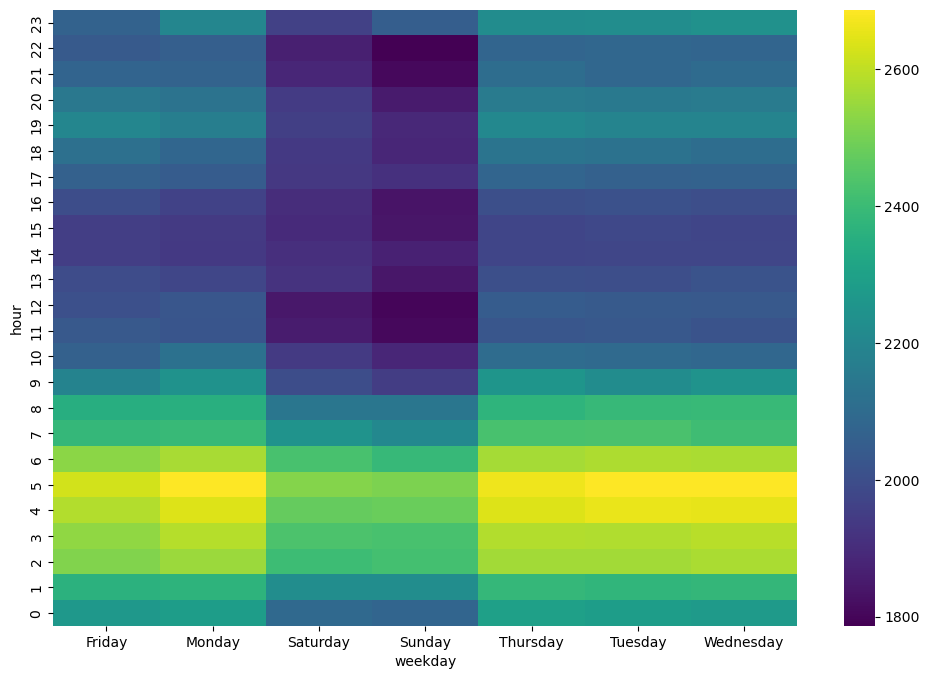

In [26]:
#plotting a heatmap with a colorbar; the colorbar shows the energy consumption in MWH
plt.figure(figsize=(12, 8))
sns.heatmap(w_hr.sort_index(ascending = False), cmap='viridis')
ax.set_title("Average energy consumption in MWH for each hour of each weekday averaged over 5 years", fontsize = 14)

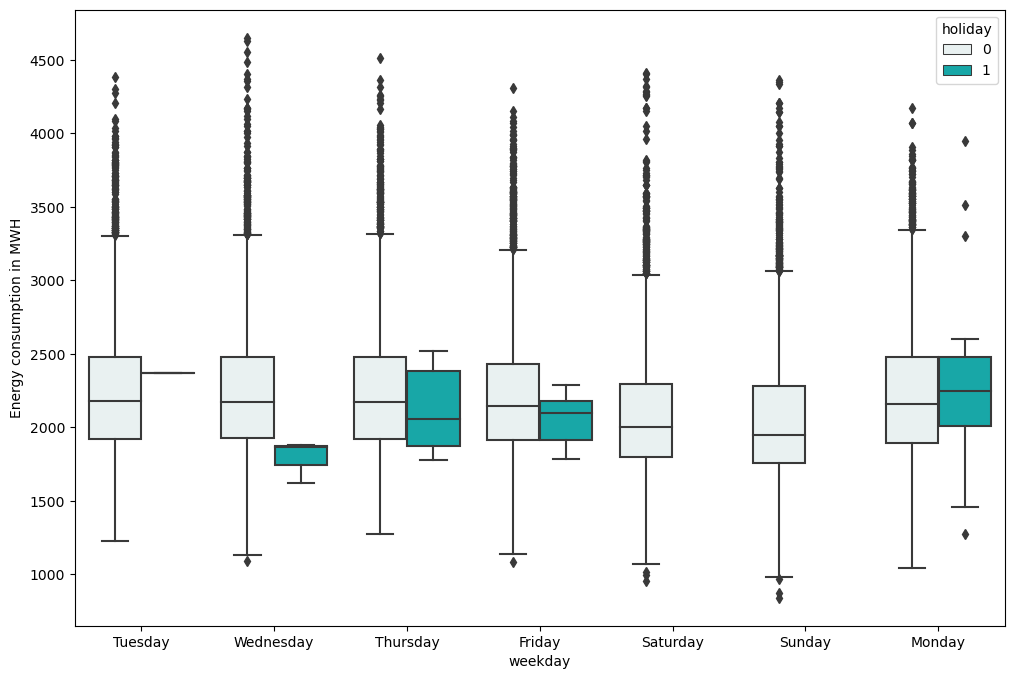

In [23]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'weekday', y = 'SDGE', data = sdge, color='c', hue='holiday')
plt.ylabel('Energy consumption in MWH')

#### Daily
Daily consumption is not very constant as seen below, leading us to believe there's high fluctuation in energy consumption in sandiego. This could be as a result of solar energy where san diego is one of the leading county's leading in renewable and natural energy. For future work in this project we'd have to consider solar installation to understand the trend better.

#### Temperature
As seen in the graph below energy and consumption are re;lated where temperature is high energy consumption increases. This also explains our previous peak points of the year being in the summer and early autumn, where weather is the highest.

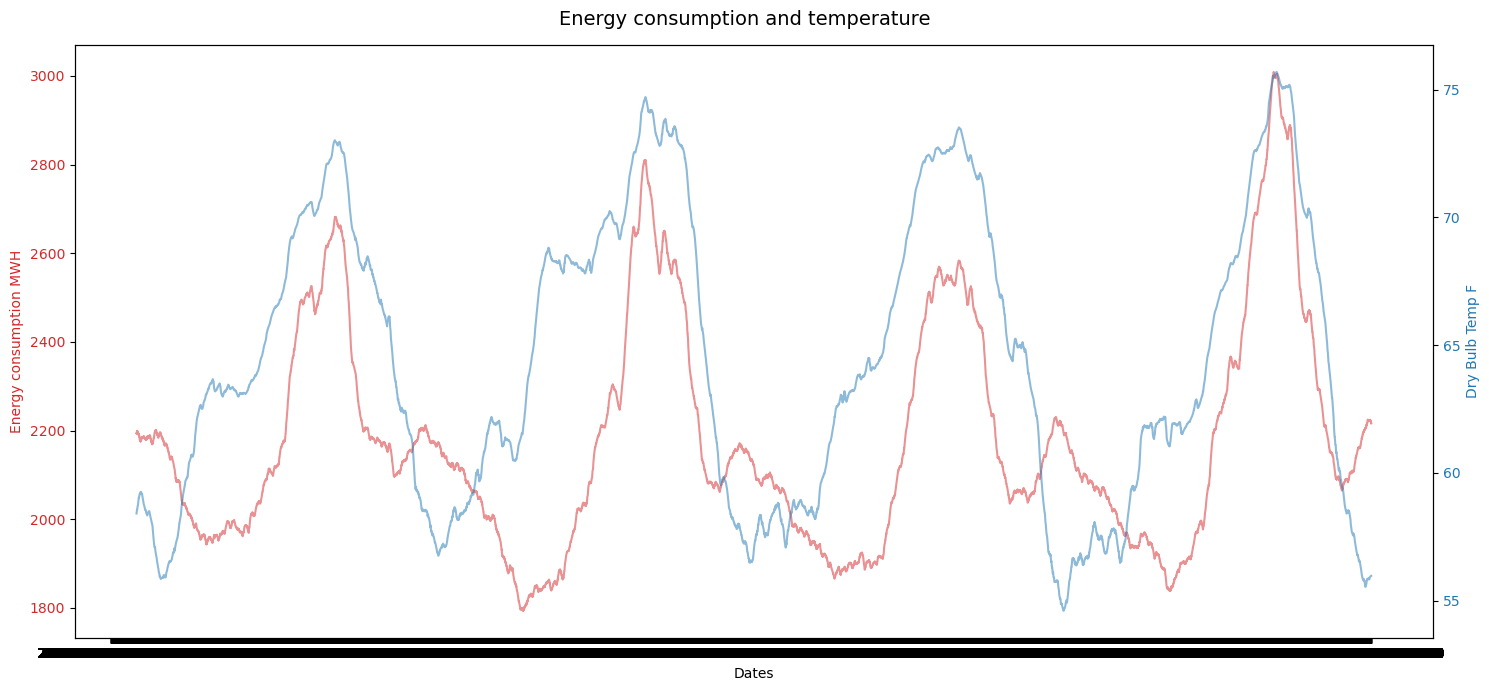

In [28]:
# Plotting the energy and weather data on the same graph as line plots
fig, ax1 = plt.subplots(figsize=(15,7))
rolling_num = 24*30 # smoothing the data a bit by taking the mean of last 'rolling_num' values 
#i.e. plotting the 30 day average energy consumption and temperature values 
color = 'tab:red'
ax1.set_xlabel('Dates')
ax1.set_ylabel('Energy consumption MWH', color = color)
ax1.plot(sdge['SDGE'].rolling(rolling_num).mean(), color = color, alpha = 0.5)        
ax1.tick_params(axis='y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Dry Bulb Temp F', color = color)  # we already handled the x-label with ax1
ax2.plot(sdge['HourlyDryBulbTemperature'].rolling(rolling_num).mean(), color = color, alpha = 0.5)   
ax2.tick_params(axis='y', labelcolor = color)

fig.suptitle('Energy consumption and temperature', fontsize = 14)
fig.tight_layout()
plt.show()

In [ ]:
# Plotting the energy and weather data on the same graph as line plots
fig, ax1 = plt.subplots(figsize=(15,7))
rolling_num = 24*30 # smoothing the data a bit by taking the mean of last 'rolling_num' values 
#i.e. plotting the 30 day average energy consumption and temperature values 
color = 'tab:red'
ax1.set_xlabel('Dates')
ax1.set_ylabel('Energy consumption MWH', color = color)
ax1.plot(sdge['SDGE'].rolling(rolling_num).mean(), color = color, alpha = 0.5)        
ax1.tick_params(axis='y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Dry Bulb Temp F', color = color)  # we already handled the x-label with ax1
ax2.plot(sdge['HourlyDryBulbTemperature'].rolling(rolling_num).mean(), color = color, alpha = 0.5)   
ax2.tick_params(axis='y', labelcolor = color)

fig.suptitle('Energy consumption and temperature plotted together', fontsize = 14)
fig.tight_layout()
plt.show()

# Time series structures
>- Hourly

In [11]:
# Creating a simple time series dataframe
th_sdge = pd.DataFrame(sdge["SDGE"], columns=['SDGE'])

In [8]:
th_sdge.head()

SDGE
datetime                        
2019-01-01 00:00:00  2372.497411
2019-01-01 01:00:00  2698.751137
2019-01-01 02:00:00  2777.672120
2019-01-01 03:00:00  2799.193829
2019-01-01 04:00:00  2761.883322

2019-01-01 00:00:00     43.285239
2019-01-01 01:00:00    149.527611
2019-01-01 02:00:00    330.518297
2019-01-01 03:00:00    351.247265
2019-01-01 04:00:00    407.755806
Freq: H, Name: seasonal, dtype: float64


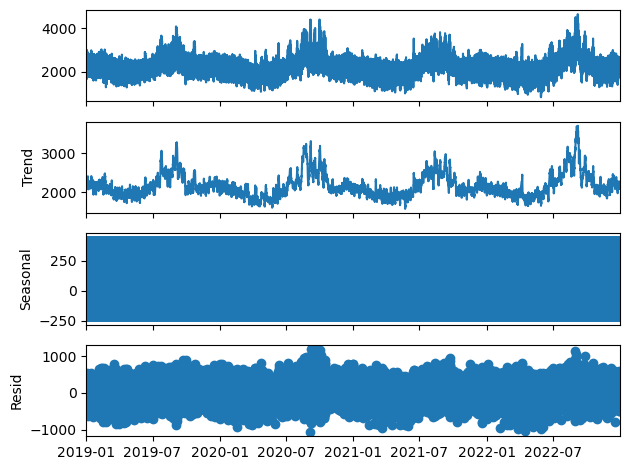

In [9]:
# Specify the start and end dates within the range of the data 
start_date = th_sdge.index[0] 
end_date = th_sdge.index[-1]  
# Create a DateTimeIndex with a frequency of 1 hour 
index = pd.date_range(start=start_date, end=end_date, freq='H')  
# Create a Series with the 'SDGE' column and the DateTimeIndex 
sdge_th = pd.Series(th_sdge['SDGE'].values, index=index)  
# Run seasonal decomposition 
decomp = sm.tsa.seasonal_decompose(sdge_th)  
# Print the first few values of the seasonal component 
print(decomp.seasonal.head())  
# Plot the decomposition 
_ = decomp.plot() 

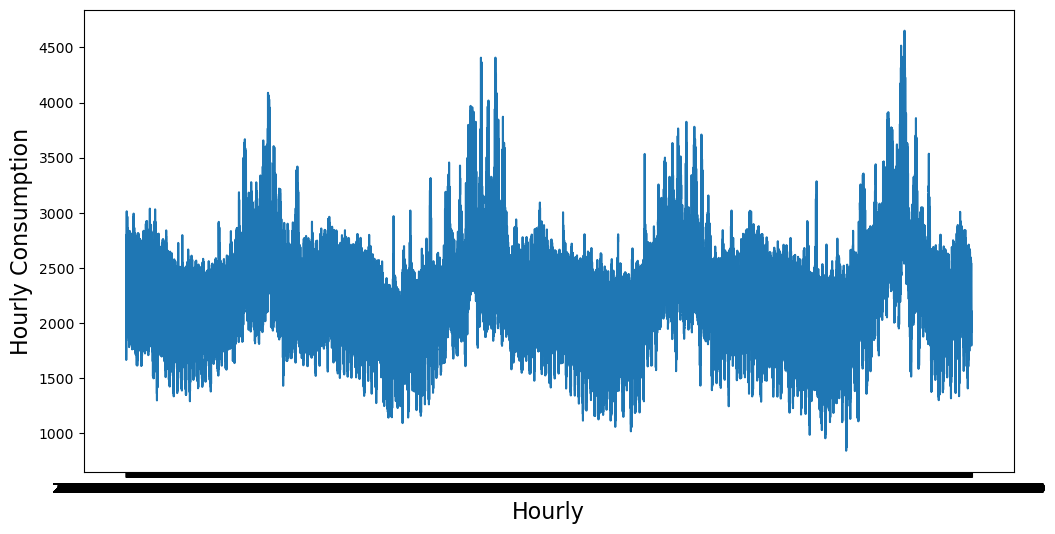

In [10]:
fig = plt.figure(figsize=(12, 6))
plt.plot(th_sdge)
plt.xlabel("Hourly", fontsize=16)
plt.ylabel("Hourly Consumption", fontsize=16)
plt.show()

In [15]:
sdge_th['seasonal'] = decomp.seasonal

## Testing for stationary
Based on the provided information, the test statistic is -8.697959e+00 and the p-value is 3.878533e-14. 
If the p-value is less than the significance level (commonly 0.05), we reject the null hypothesis 
and conclude that the time series is stationary. 

In this case, the p-value (3.878533e-14) is much smaller than the significance level (0.05), 
indicating strong evidence against the null hypothesis. We can therefore conclude that the time series is stationary.

In [20]:
th_test = adfuller(th_sdge)
display(th_test)

(-8.69795881318699,
 3.878533167943309e-14,
 52,
 35011,
 {'1%': -3.43053679213716,
  '5%': -2.8616225575095284,
  '10%': -2.566813942767471},
 475245.4656370086)

In [21]:
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(
                th_test[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
)

for key,value in th_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

Test Statistic                -8.697959e+00
p-value                        3.878533e-14
#Lags Used                     5.200000e+01
Number of Observations Used    3.501100e+04
Critical Value (1%)           -3.430537e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64

### Daily

In [11]:
td_sdge = pd.DataFrame(SDGE_T["SDGE"], columns=['SDGE'])

In [12]:
td_sdge.isna().sum()

SDGE    0
dtype: int64

In [24]:
td_sdge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2019-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SDGE    35064 non-null  float64
dtypes: float64(1)
memory usage: 547.9+ KB


In [25]:
# Convert index to datetime format 
td_sdge.index = pd.to_datetime(td_sdge.index)  
# Resample to daily frequency and calculate mean 
td_sdge = td_sdge.resample('D').mean() 

2019-01-01     61.832640
2019-01-02     60.913453
2019-01-03     61.671525
2019-01-04     28.503452
2019-01-05   -111.327743
Freq: D, Name: seasonal, dtype: float64


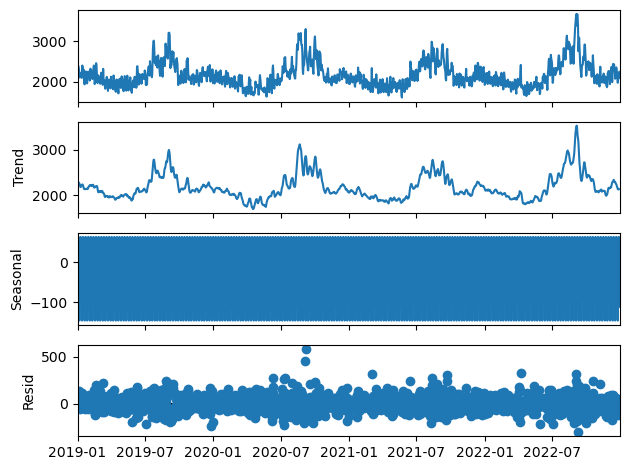

In [26]:
# Specify the start and end dates within the range of the data 
start_date = td_sdge.index[0] 
end_date = td_sdge.index[-1]  
# Create a DateTimeIndex with a frequency of 1 hour 
index = pd.date_range(start=start_date, end=end_date, freq='D')  
# Create a Series with the 'SDGE' column and the DateTimeIndex 
td_sdge = pd.Series(td_sdge['SDGE'].values, index=index)  
# Run seasonal decomposition 
decomp = sm.tsa.seasonal_decompose(td_sdge)  
# Print the first few values of the seasonal component 
print(decomp.seasonal.head())  
# Plot the decomposition 
_ = decomp.plot() 

>- Daily stationary status

In [27]:
td_test = adfuller(td_sdge)
display(td_test)

(-3.152514268847381,
 0.02290319689547403,
 21,
 1439,
 {'1%': -3.4349024693573584,
  '5%': -2.8635506057382325,
  '10%': -2.5678404322793846},
 17459.226734458396)

In [28]:
for key,value in td_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

Test Statistic                -8.697959e+00
p-value                        3.878533e-14
#Lags Used                     5.200000e+01
Number of Observations Used    3.501100e+04
Critical Value (1%)           -3.434902e+00
Critical Value (5%)           -2.863551e+00
Critical Value (10%)          -2.567840e+00
dtype: float64

### Weekly

In [29]:
tw_sdge = pd.DataFrame(SDGE_T["SDGE"], columns=['SDGE'])

In [30]:
# Convert index to datetime format 
tw_sdge.index = pd.to_datetime(tw_sdge.index)  
# Resample to weekly frequency and calculate mean 
tw_sdge = tw_sdge.resample('W').mean() 

2019-01-06   -41.327466
2019-01-13   -20.950110
2019-01-20   -44.980603
2019-01-27   -67.622577
2019-02-03   -45.524346
Freq: W-SUN, Name: seasonal, dtype: float64


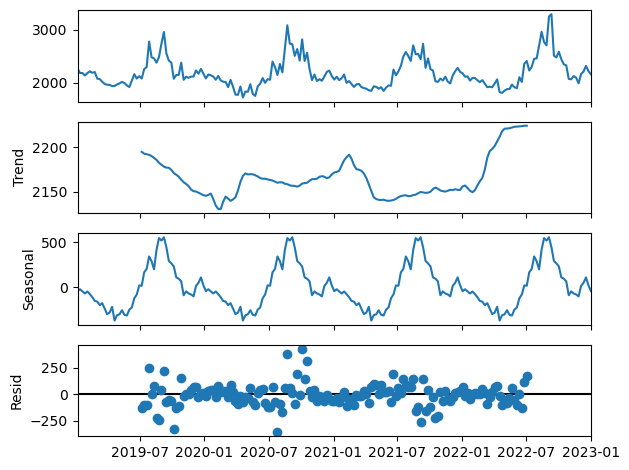

In [31]:
# Specify the start and end dates within the range of the data 
start_date = tw_sdge.index[0] 
end_date = tw_sdge.index[-1]  
# Create a DateTimeIndex with a frequency of 1 hour 
index = pd.date_range(start=start_date, end=end_date, freq='W')  
# Create a Series with the 'SDGE' column and the DateTimeIndex 
tw_sdge = pd.Series(tw_sdge['SDGE'].values, index=index)  
# Run seasonal decomposition 
decomp = sm.tsa.seasonal_decompose(tw_sdge)  
# Print the first few values of the seasonal component 
print(decomp.seasonal.head())  
# Plot the decomposition 
_ = decomp.plot() 

>- Weekly stationary

In [32]:
tw_test = adfuller(tw_sdge)
display(tw_test)

(-4.822109515634576,
 4.9329760354863376e-05,
 7,
 201,
 {'1%': -3.4633090972761744,
  '5%': -2.876029332045744,
  '10%': -2.5744932593252643},
 2484.005492816163)

In [33]:
for key,value in tw_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

Test Statistic                -8.697959e+00
p-value                        3.878533e-14
#Lags Used                     5.200000e+01
Number of Observations Used    3.501100e+04
Critical Value (1%)           -3.463309e+00
Critical Value (5%)           -2.876029e+00
Critical Value (10%)          -2.574493e+00
dtype: float64

### Monthly

In [34]:
tm_sdge = pd.DataFrame(SDGE_T["SDGE"], columns=['SDGE'])

In [35]:
# Convert index to datetime format 
tm_sdge.index = pd.to_datetime(tm_sdge.index)  
# Resample to daily frequency and calculate mean 
tm_sdge = tm_sdge.resample('M').mean() 

2019-01-31    -50.599983
2019-02-28   -127.433425
2019-03-31   -229.471950
2019-04-30   -292.418495
2019-05-31   -287.704334
Freq: M, Name: seasonal, dtype: float64


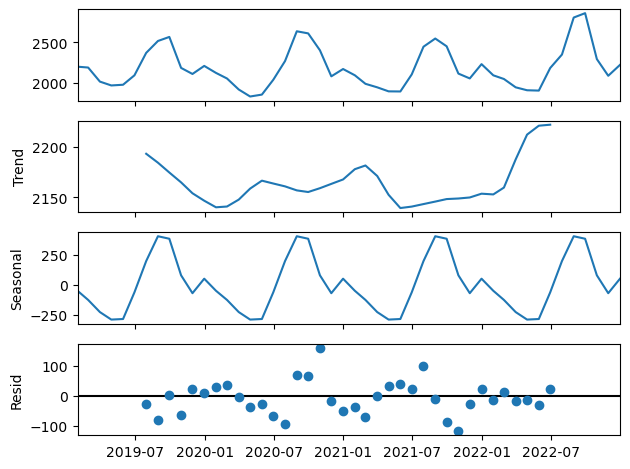

In [36]:
# Specify the start and end dates within the range of the data 
start_date = tm_sdge.index[0] 
end_date = tm_sdge.index[-1]  
# Create a DateTimeIndex with a frequency of 1 hour 
index = pd.date_range(start=start_date, end=end_date, freq='M')  
# Create a Series with the 'SDGE' column and the DateTimeIndex 
tm_sdge = pd.Series(tm_sdge['SDGE'].values, index=index)  
# Run seasonal decomposition 
decomp = sm.tsa.seasonal_decompose(tm_sdge)  
# Print the first few values of the seasonal component 
print(decomp.seasonal.head())  
# Plot the decomposition 
_ = decomp.plot() 

In [ ]:
decomp.

### Yearly

In [17]:
ty_sdge = pd.DataFrame(sdge["SDGE"], columns=['SDGE'])

In [18]:
# Convert index to datetime format 
ty_sdge.index = pd.to_datetime(ty_sdge.index)  
# Resample to daily frequency and calculate mean 
ty_sdge = ty_sdge.resample('Y').mean() 

In [20]:
ty_sdge

SDGE
Date                   
2019-12-31  2196.318828
2020-12-31  2162.799640
2021-12-31  2144.773053
2022-12-31  2222.247379

2019-12-31    0.0
2020-12-31    0.0
2021-12-31    0.0
2022-12-31    0.0
Freq: A-DEC, Name: seasonal, dtype: float64


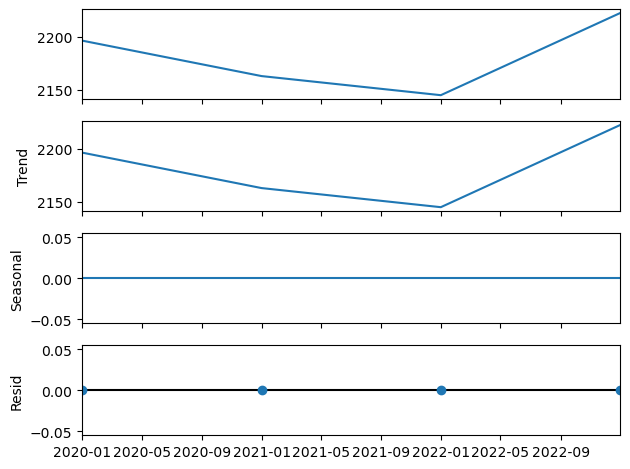

In [21]:
# Specify the start and end dates within the range of the data 
start_date = ty_sdge.index[0] 
end_date = ty_sdge.index[-1]  
# Create a DateTimeIndex with a frequency of 1 hour 
index = pd.date_range(start=start_date, end=end_date, freq='Y')  
# Create a Series with the 'SDGE' column and the DateTimeIndex 
ty_sdge = pd.Series(ty_sdge['SDGE'].values, index=index)  
# Run seasonal decomposition 
decomp = sm.tsa.seasonal_decompose(ty_sdge)  
# Print the first few values of the seasonal component 
print(decomp.seasonal.head())  
# Plot the decomposition 
_ = decomp.plot() 

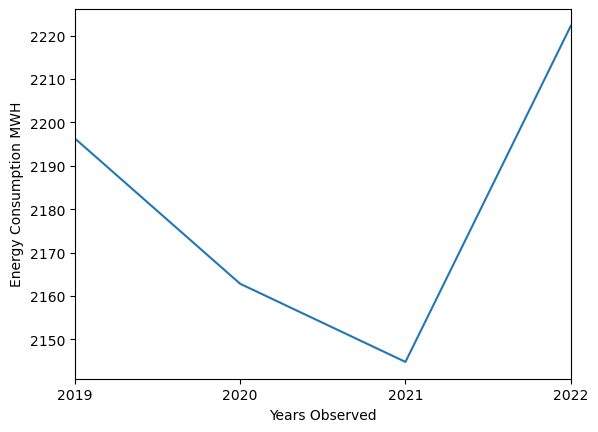

In [25]:
decomp.trend.plot()
plt.ylabel('Energy Consumption MWH')
plt.xlabel('Years Observed')
plt.show()

In [37]:
tm_test = adfuller(tm_sdge)
display(tm_test)

(-1.4759501957019538,
 0.5453731225370553,
 10,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 466.06945982473326)

In [38]:
for key,value in tm_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

Test Statistic                -8.697959e+00
p-value                        3.878533e-14
#Lags Used                     5.200000e+01
Number of Observations Used    3.501100e+04
Critical Value (1%)           -3.620918e+00
Critical Value (5%)           -2.943539e+00
Critical Value (10%)          -2.610400e+00
dtype: float64

In [45]:
ts_sdge = pd.DataFrame(SDGE_T["SDGE"], columns=['SDGE'])

In [46]:
# Defining a function to plot exponentially smoothed data
def plot_ewma(ts, alpha):
    expw_ma = ts.ewm(alpha=alpha).mean()
    
    plot_ts_pred(ts, expw_ma, model_name='Exponentially smoothed data with alpha = {}'.format(alpha), \
                 og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

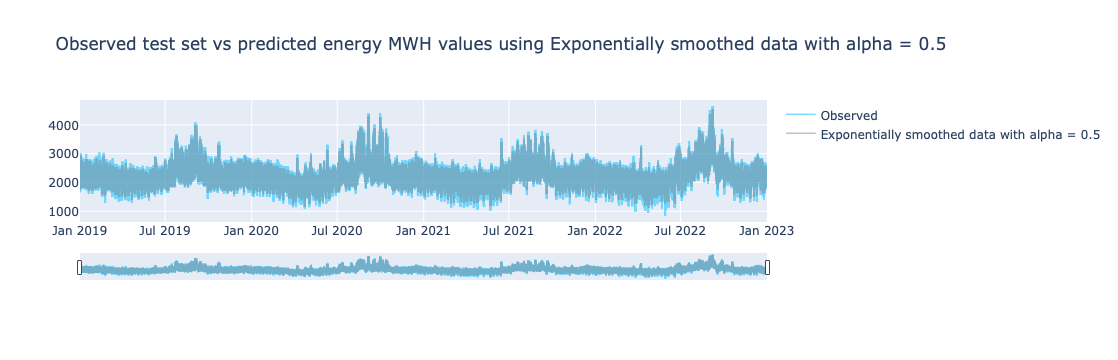

In [48]:
# Plotting the exponentially smoothed energy consumption data with alpha=0.5
plot_ewma(ts_sdge['SDGE'], 0.5)